I get the following output from the code below:
```
SN2006aj_53786.270000
Filter_area =  958.904702526
Integrated flux =  65.3955702281
SN2006aj_53787.230000
Filter_area =  583.185950131
Integrated flux =  41.0298233406
SN2006aj_53788.200000
Filter_area =  1358.72907164
Integrated flux =  131.886385781
SN2006aj_53789.170000
Filter_area =  1357.72217486
Integrated flux =  146.521717503
SN2006aj_53790.140000
Filter_area =  1361.80653493
Integrated flux =  164.34213622
SN2006aj_53791.100000
Filter_area =  1356.94789874
Integrated flux =  163.802182486
SN2006aj_53792.070000
Filter_area =  1358.08475139
Integrated flux =  170.17603978
SN2006aj_53793.040000
Filter_area =  1342.63870674
Integrated flux =  156.866851118
SN2006aj_53794.010000
Filter_area =  1358.55873129
Integrated flux =  160.605022385
SN2006aj_53794.970000
Filter_area =  494.406955809
Integrated flux =  64.3739416067
SN2006aj_53795.940000
Filter_area =  1315.20012487
Integrated flux =  137.109302356
SN2006aj_53796.910000
Filter_area =  1313.60589901
Integrated flux =  121.107583058
SN2006aj_53797.880000
Filter_area =  1313.47758368
Integrated flux =  110.196456176
SN2006aj_53798.840000
Filter_area =  1315.40072684
Integrated flux =  92.2847571523
SN2006aj_53799.810000
Filter_area =  1314.80756892
Integrated flux =  91.8528874753
SN2006aj_53801.750000
Filter_area =  1298.16443106
Integrated flux =  63.0384962734
SN2006aj_53802.720000
Filter_area =  1299.82908919
Integrated flux =  45.3544694847
SN2006aj_53803.680000
Filter_area =  1296.91402526
Integrated flux =  37.1949955268
SN2006aj_53803.680001
Filter_area =  1296.93821395
Integrated flux =  51.5059756933```

Notice something weird - the filter area is changing. The filter area shouldn't change. Suspect that it might be to do with the resampling of the filter response, but the fluctuations are severe -  around 1300 for most, but as low as 494 for SN2006aj_53794.970000.

In [1]:
%matplotlib notebook

from matplotlib import pyplot as plt

import os
import numpy as np
from astropy.table import Table

import pycoco as pcc

<IPython.core.display.Javascript object>


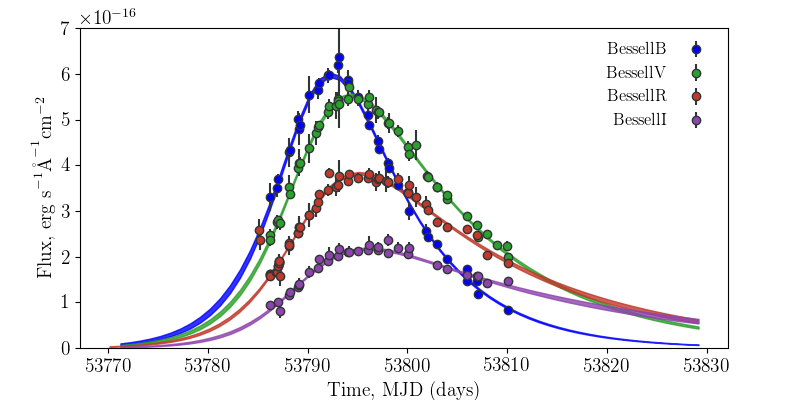

SN2006aj_53786.270000
min wavelength =  1500.44922166
max wavelength =  24759.6449687
resampling the response
min wavelength =  3540.3
max wavelength =  7272.03
Filter_area =  958.904702526
Integrated flux =  65.3955702281
SN2006aj_53787.230000
min wavelength =  3540.3
max wavelength =  7272.03
resampling the response
min wavelength =  4263.57
max wavelength =  9633.22
Filter_area =  583.185950131
Integrated flux =  41.0298233406
SN2006aj_53788.200000
min wavelength =  4263.57
max wavelength =  9633.22
resampling the response
min wavelength =  3386.88
max wavelength =  9676.79
Filter_area =  1358.72907164
Integrated flux =  131.886385781
SN2006aj_53789.170000
min wavelength =  3386.88
max wavelength =  9676.79
resampling the response
min wavelength =  3388.16
max wavelength =  9341.84
Filter_area =  1357.72217486
Integrated flux =  146.521717503
SN2006aj_53790.140000
min wavelength =  3388.16
max wavelength =  9341.84
resampling the response
min wavelength =  3383.01
max wavelength =  

In [2]:
snname="SN2006aj"

sn = pcc.classes.SNClass(snname)
sn.load_phot(verbose=False)
sn.get_lcfit(os.path.join(pcc.defaults._default_recon_dir_path, snname + ".dat"))

sn.plot_lc(multiplot=False)

sn.load_list(path=os.path.join(pcc.defaults._default_list_dir_path, sn.name+".list"))
sn.load_spec()

# sn.load_mangledspec()
sn.load_reconspec()
sn.load_simspec()


path_to_filter = os.path.join(pcc.defaults._default_filter_dir_path,"BessellB.dat")
BessellB = pcc.classes.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()

sim_spec_flux = []
sim_mjd_obs = []

for spec in sn.sim_spec:
    print(spec)
    flux = pcc.kcorr.calc_spectrum_filter_flux(filter_object=BessellB, spectrum_object=sn.sim_spec[spec], 
                                               correct_for_area=False)
    mjd_obs = float(spec.split("_")[-1])
    
    sim_spec_flux.append(flux)
    sim_mjd_obs.append(mjd_obs)
    

After running the above, the filter object that has been loaded in is totally messed up:
<img src="notebook_files/Filter_integration_bughunt_Fig1-BessellB_after_some_resampling.png">

It should look like this:

<IPython.core.display.Javascript object>


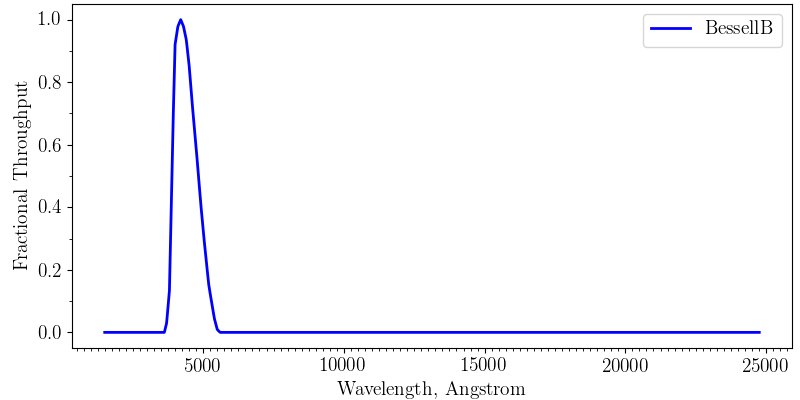

In [3]:
path_to_filter = os.path.join(pcc.defaults._default_filter_dir_path,"BessellB.dat")
BessellB = pcc.classes.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()
BessellB.plot()

the resample_response at this point looks like this:

```python
def resample_response(self, new_wavelength = False, k = 1, verbose=False,
                      *args, **kwargs):
    """
    Bit dodgy - spline has weird results for poorly sampled filters.
    Now the order is by default 1, seems to be less likely to introduce artifacts

    Parameters
    ----------

    Returns
    -------
    """

    if hasattr(self, "wavelength") and hasattr(self, "throughput"):

        if verbose: print("resampling response")

        self._wavelength_orig = self.wavelength
        self._throughput_orig = self.throughput

        self.wavelength = np.concatenate(([0,1], self._wavelength_orig, [24999,25000]))
        self.throughput = np.concatenate(([0,0], self._throughput_orig, [0,0]))

        interp_func = InterpolatedUnivariateSpline(self.wavelength, self.throughput, k = k,
                                                   *args, **kwargs)
        self.throughput = interp_func(new_wavelength)
        self.wavelength = new_wavelength
        # self.wavelength.name = "wavelength"

        self.throughput[np.where(self.throughput < 0.0)] = 0.0
    else:
        warning.warn("Doesn't look like you have loaded a filter into the object")
```

... that docstring does _not_ inspire confidence, does it. Need to be a bit more careful. However, with the concatenation, it should be the case that there are throughput zeros at both extremes of the wavelength - in the messed up example, this is clearly not the case.

<IPython.core.display.Javascript object>


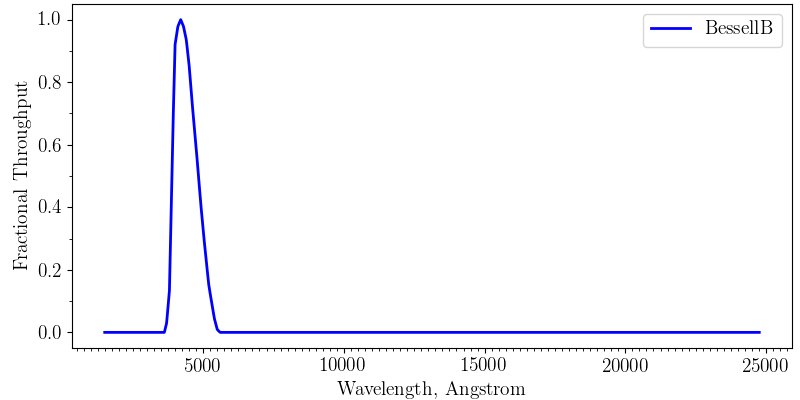

958.897101114
958.897101114
958.897101114


<IPython.core.display.Javascript object>


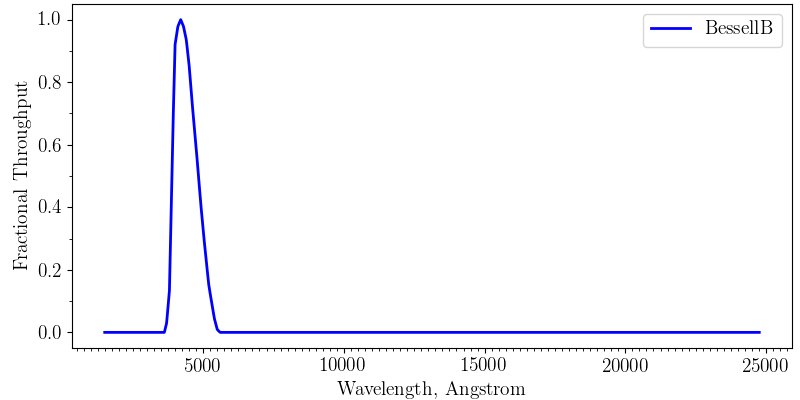

In [4]:
path_to_filter = os.path.join(pcc.defaults._default_filter_dir_path,"BessellB.dat")
BessellB = pcc.classes.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()
BessellB.plot()
print(BessellB._effective_area)
print(pcc.kcorr.calc_filter_area(filter_object=BessellB))
print(pcc.kcorr.calc_filter_area(filter_name="BessellB"))
BessellB.plot()

<IPython.core.display.Javascript object>


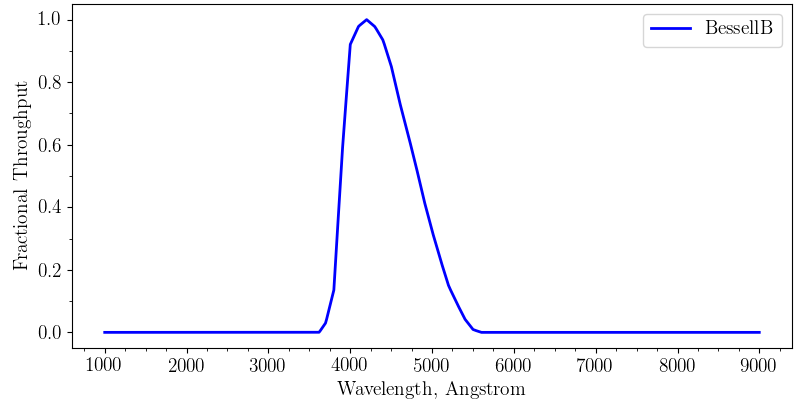

958.897101114
958.897101114
958.897101114


In [5]:
BessellB.resample_response(new_wavelength=np.arange(1000.0,9000.0, 1.0))
BessellB.plot()
print(BessellB._effective_area)
print(pcc.kcorr.calc_filter_area(filter_object=BessellB))
print(pcc.kcorr.calc_filter_area(filter_name="BessellB"))

So the filter area without any resampling is 958.9. Am I calculating this correctly? Resampling doesn't seem to affect the area.

<IPython.core.display.Javascript object>


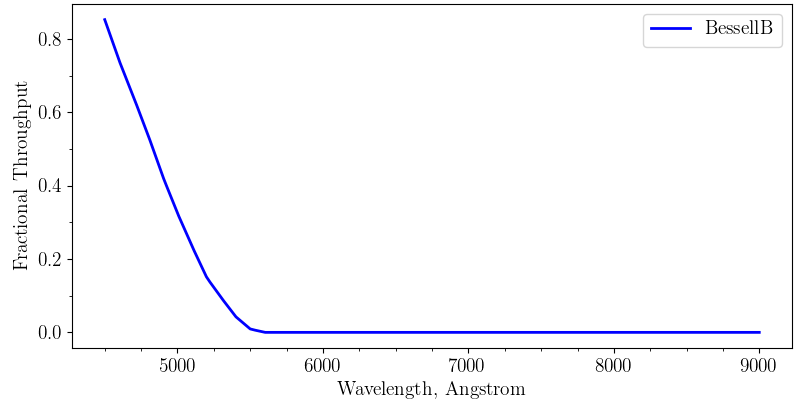

958.897101114
958.897101114
958.897101114


In [6]:
BessellB.resample_response(new_wavelength=np.arange(4500.0,9000.0, 1.0))
BessellB.plot()
print(BessellB._effective_area)
print(pcc.kcorr.calc_filter_area(filter_object=BessellB))
print(pcc.kcorr.calc_filter_area(filter_name="BessellB"))

<IPython.core.display.Javascript object>


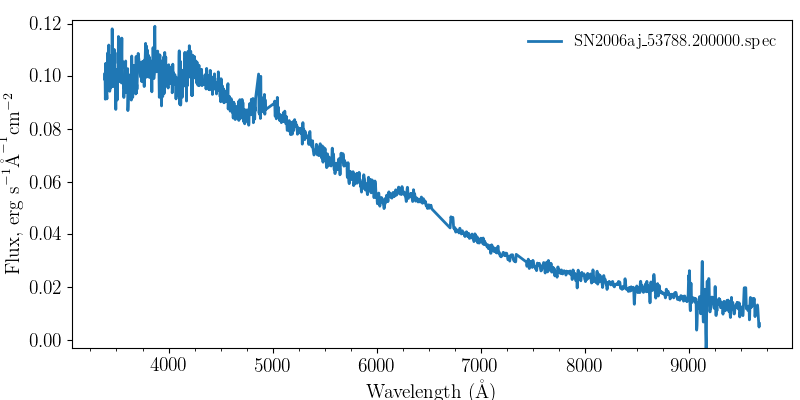

In [7]:
spec = pcc.classes.SpectrumClass()
specname = "SN2006aj_53788.200000.spec"

spec.load(filename = os.path.join(pcc.defaults._default_specphase_dir_path, specname), abspath=True)
spec.plot()

min wavelength =  4500.0
max wavelength =  8999.0
resampling the response
min wavelength =  3386.88
max wavelength =  9676.79
Filter_area =  1194.24842314
Integrated flux =  115.301214833
0.0965470940545


<IPython.core.display.Javascript object>


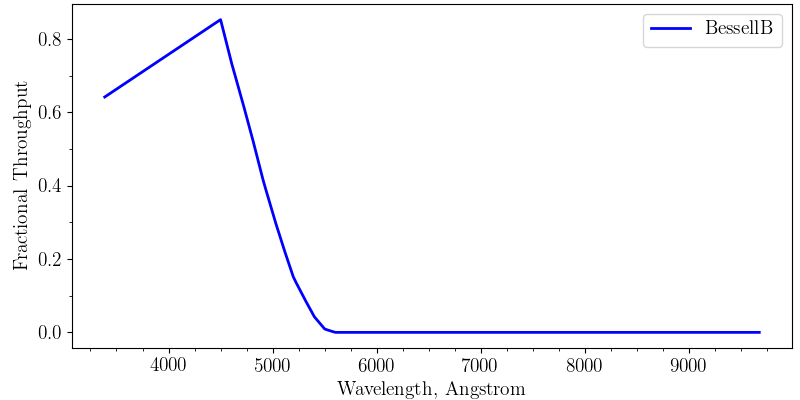

In [8]:
flux = pcc.kcorr.calc_spectrum_filter_flux(filter_object=BessellB, spectrum_object=spec, 
                                           correct_for_area=True, verbose=True)
print(flux)
BessellB.plot()

It looks like going back to a longer spectrum after a cropped and resampled one causes problems. If I run the `calc_spectrum_filter_flux` with a reloaded filter every time it might give me different results.

In [9]:
sim_spec_flux_from_object = []
sim_spec_flux = []
sim_mjd_obs = []

for spec in sn.sim_spec:
#     print(spec)
    flux = pcc.kcorr.calc_spectrum_filter_flux(filter_name="BessellB", spectrum_object=sn.sim_spec[spec], 
                                               correct_for_area=True, verbose=False)
    flux_from_object = pcc.kcorr.calc_spectrum_filter_flux(filter_object=BessellB, spectrum_object=sn.sim_spec[spec], 
                                               correct_for_area=True, verbose=False)
    print(flux, flux_from_object)
    mjd_obs = float(spec.split("_")[-1])
    
    sim_spec_flux.append(flux)
    sim_spec_flux_from_object.append(flux_from_object)
    
    sim_mjd_obs.append(mjd_obs)

0.0681981953533 0.0681502713684
0.0703546166221 0.0701954395629
0.0952230850925 0.0965469897738
0.107621350594 0.107529497841
0.119768136655 0.120320638291
0.128729725263 0.121050105658
0.132208011408 0.125692565403
0.133922294034 0.118096168107
0.129547936621 0.119260622462
0.130204294446 0.129933844101
0.114518764848 0.105089299754
0.106609304644 0.0933475489263
0.0958183495558 0.0849714776482
0.0912305712487 0.072058782156
0.0792164587547 0.0709007368105
0.0638949428945 0.0499113387599
0.0610673471322 0.0370521507522
0.0539330243157 0.030758882816
0.0504622641925 0.0408396520279


<IPython.core.display.Javascript object>


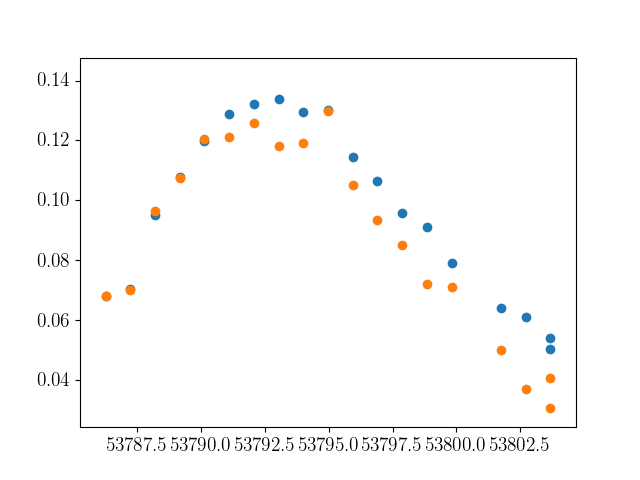

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sim_mjd_obs, sim_spec_flux)
ax.scatter(sim_mjd_obs, sim_spec_flux_from_object)

Aha! That has definitely improved matters. However - I need to check the mangling - there are still some points that don't looks right at all. This could well be due to this bug having unforseen consequences. I'll change the mode and run it through again.

When resampling already preserves the original information:
```python
            self._wavelength_orig = self.wavelength
            self._throughput_orig = self.throughput
```

Also, `self.data` doesn't change. Adding a 'revert' method.

In [12]:
path_to_filter = os.path.join(pcc.defaults._default_filter_dir_path,"BessellB.dat")
BessellB = pcc.classes.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()

sim_spec_flux_with_revert = []
sim_spec_flux = []
sim_mjd_obs = []

for spec in sn.sim_spec:
#     print(spec)
    flux = pcc.kcorr.calc_spectrum_filter_flux(filter_name="BessellB", spectrum_object=sn.sim_spec[spec], 
                                               correct_for_area=True, verbose=False)
    BessellB.revert(verbose=True)
    flux_with_revert = pcc.kcorr.calc_spectrum_filter_flux(filter_object=BessellB, spectrum_object=sn.sim_spec[spec], 
                                               correct_for_area=True, verbose=False)
    print(flux, flux_with_revert)
    mjd_obs = float(spec.split("_")[-1])
    
    sim_spec_flux.append(flux)
    sim_spec_flux_with_revert.append(flux_with_revert)
    
    sim_mjd_obs.append(mjd_obs)

reverting to original response
0.0681981953533 0.0681981953533
reverting to original response
0.0703546166221 0.0703546166221
reverting to original response
0.0952230850925 0.0952230850925
reverting to original response
0.107621350594 0.107621350594
reverting to original response
0.119768136655 0.119768136655
reverting to original response
0.128729725263 0.128729725263
reverting to original response
0.132208011408 0.132208011408
reverting to original response
0.133922294034 0.133922294034
reverting to original response
0.129547936621 0.129547936621
reverting to original response
0.130204294446 0.130204294446
reverting to original response
0.114518764848 0.114518764848
reverting to original response
0.106609304644 0.106609304644
reverting to original response
0.0958183495558 0.0958183495558
reverting to original response
0.0912305712487 0.0912305712487
reverting to original response
0.0792164587547 0.0792164587547
reverting to original response
0.0638949428945 0.0638949428945
reverting 

<IPython.core.display.Javascript object>


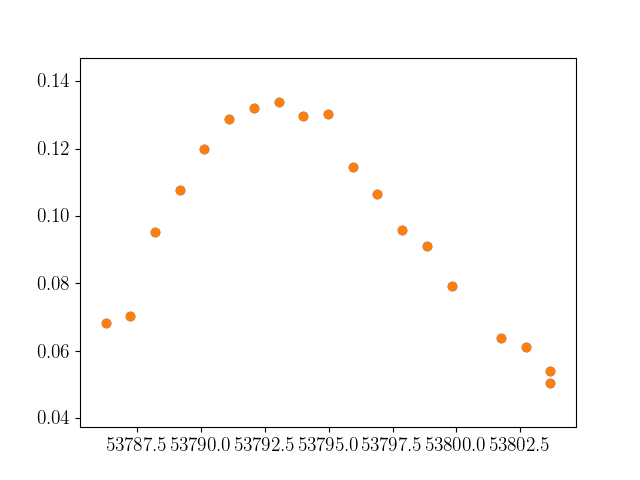

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sim_mjd_obs, sim_spec_flux)
ax.scatter(sim_mjd_obs, sim_spec_flux_with_revert)

ok, that's figured out, I'm going to insert a self.revert into the resample by default.